# Выбор локации для скважины

## Цели и задачи исследования

### Предоставленные данные и исходные предпосылки

У нас есть данные о нефти в трех регионах. Были измерены качество нефти и объем запасов сырья. 

Бюджет на разработку новых скважин — 10 млрд рублей.

Из 500 возможных точек необходимо выбрать 200 лучших для разработки.

Стоимость одного барреля — 450 рублей. Объем сырья указан в тысячах баррелей.


### Цель исследования

Определить регион для разработки новых нефтяных скважин с учетом объема прибыли и возможных рисков.

### Задачи исследования

1. С использованием модели линейной регрессии спрогнозировать средний запас сырья в регионе
2. Рассчитать достаточный объем сырья для безубыточной разработки новой скважины и сравнить этот показатель со средним запасом сырья в каждом регионе
3. Выбрать скважины с максимальными предсказанными значениями и определить суммарный объем сырья по реальным значениям на этих скважинах. Рассчитать прибыль
4. Построить распределение прибыли, найти доверительный интервал для прибыли и рассчитать риск убытков (с использованием бутстрапа)
5. Предложить для разработки новых скважин регион с наибольшей средней прибылью, в котором вероятность убытков не превышает 2.5%

## Загрузка и подготовка данных

In [1]:
# Импортируем необходимые библиотеки и функции
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')


In [2]:
# Загружаем данные по каждому региону в отдельные переменные
try:
    d1 = pd.read_csv('/datasets/geo_data_0.csv')
    d2 = pd.read_csv('/datasets/geo_data_1.csv')
    d3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    d1 = pd.read_csv('/content/geo_data_0.csv')
    d2 = pd.read_csv('/content/geo_data_1.csv')
    d3 = pd.read_csv('/content/geo_data_2.csv')

In [3]:
# Делаем функцию для проведения обзора данных
def data_overview(data):
    '''
    Функция для обзора данных,
    принимает на вход датафрейм,
    выводит на экран его основные характеристики
    и графики
    '''
    print('Первые пять строк', (80 - len('Первые пять строк')) * '-')
    display(data.head())   
    print('')
    print('Общая информация о данных (info)', (80 - len('Общая информация о данных (info)')) * '-', '\n')
    data.info()
    print('')
    print('Статистические показатели (describe)', (80 - len('Статистические показатели (describe)')) * '-')
    display(data.describe().T)
    print('')
    print ('Пропущенные значения в данных', (80 - len('Пропущенные значения в данных')) * '-')
    print('')
    empty = sum(data.isna().sum())
    if empty > 0:
        print(f'Количество пропусков в данных: {empty}')
    else:
        print('Пропущенных значений нет')
    print('')
    print('Дубликаты в данных', (80 - len('Дубликаты в данных')) * '-')
    print('')
    if data.duplicated().sum() > 0:
        print (f'Количество дубликатов в данных: {data.duplicated().sum()}')
    else:
        print('Дубликатов нет')
    print('')
    print('Корреляция между количественными признаками', (80 - len('Корреляция между количественными признаками')) * '-')
    plt.figure(figsize=(5,4))
    sns.heatmap(data.drop('id', axis=1).corr(), cmap="viridis", annot=True)
    plt.show()
    print(' ')
    print('Распределение количественных данных на гистограммах', 
          (80 - len('Распределение количественных данных на гистограммах')) * '-')
    data.hist(figsize=(15,15))
    plt.show()
    

### Регион 1

Первые пять строк ---------------------------------------------------------------


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Общая информация о данных (info) ------------------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Статистические показатели (describe) --------------------------------------------


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347



Пропущенные значения в данных ---------------------------------------------------

Пропущенных значений нет

Дубликаты в данных --------------------------------------------------------------

Дубликатов нет

Корреляция между количественными признаками -------------------------------------


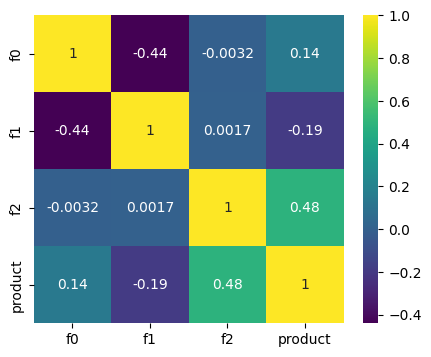

 
Распределение количественных данных на гистограммах -----------------------------


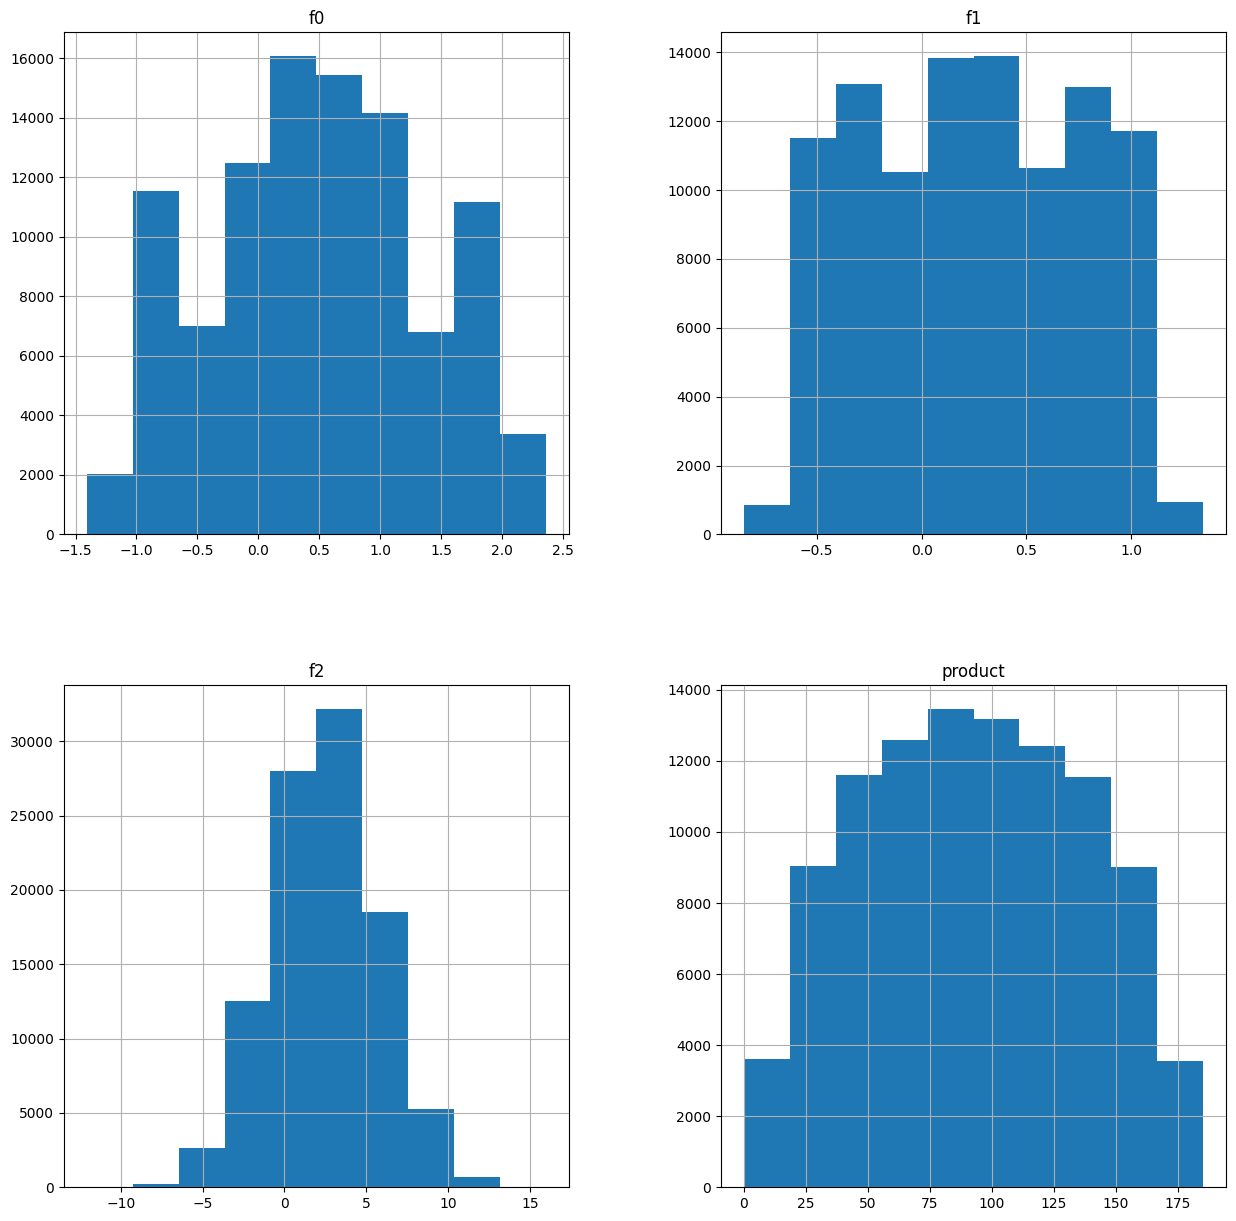

In [4]:
# Смотрим на данные по региону 1
data_overview(d1)

1. В данных по региону 1 нет пропусков и явных дубликатов, количество строк в датасете — 100_000, типы данных соответствуют значениям в столбцах. 

2. Наблюдается средняя положительная корреляция (0.48) между объемом получаемого сырья и признаком f2.

3. Значения числовых переменных являются непрерывными (это видно на гистограммах).



### Регион 2

Первые пять строк ---------------------------------------------------------------


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Общая информация о данных (info) ------------------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Статистические показатели (describe) --------------------------------------------


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408



Пропущенные значения в данных ---------------------------------------------------

Пропущенных значений нет

Дубликаты в данных --------------------------------------------------------------

Дубликатов нет

Корреляция между количественными признаками -------------------------------------


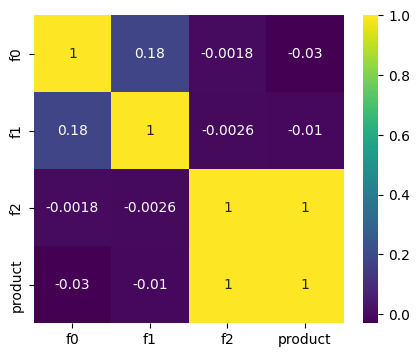

 
Распределение количественных данных на гистограммах -----------------------------


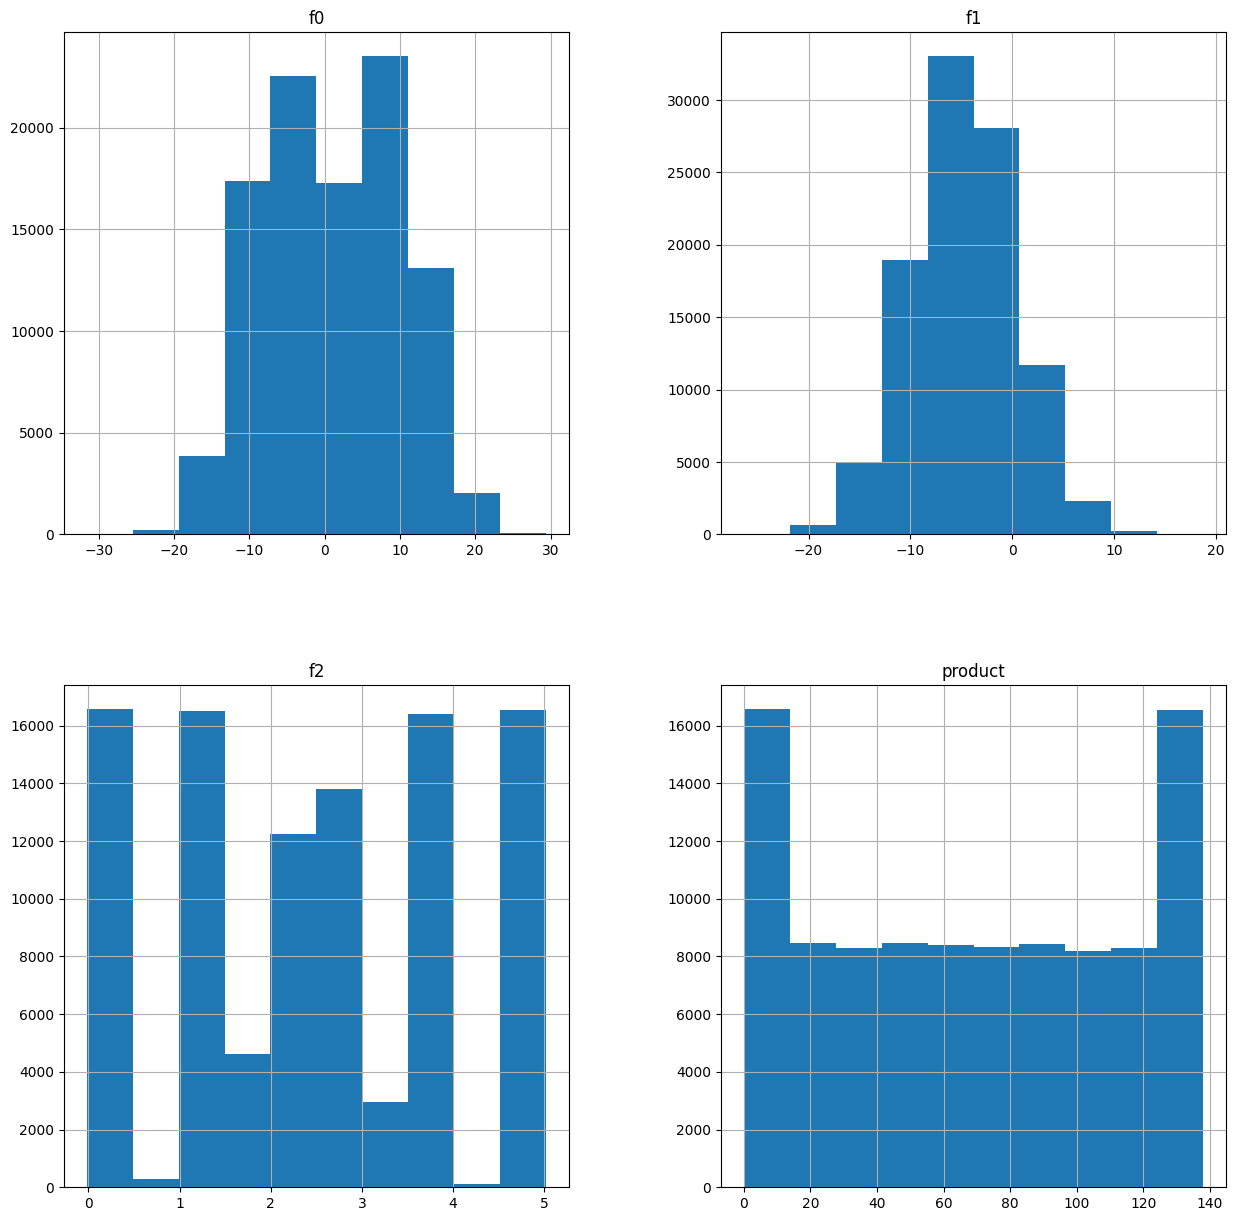

In [5]:
data_overview(d2)

1. В данных по региону 2 нет пропусков и явных дубликатов, количество строк в датасете — 100_000, типы данных соответствуют значениям в столбцах. 

2. Наблюдается сильная положительная корреляция (около 1) между объемом получаемого сырья и признаком f2, то есть мы можем говорить, что эти переменные имеют линейную связь.



### Регион 3

Первые пять строк ---------------------------------------------------------------


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



Общая информация о данных (info) ------------------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Статистические показатели (describe) --------------------------------------------


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838



Пропущенные значения в данных ---------------------------------------------------

Пропущенных значений нет

Дубликаты в данных --------------------------------------------------------------

Дубликатов нет

Корреляция между количественными признаками -------------------------------------


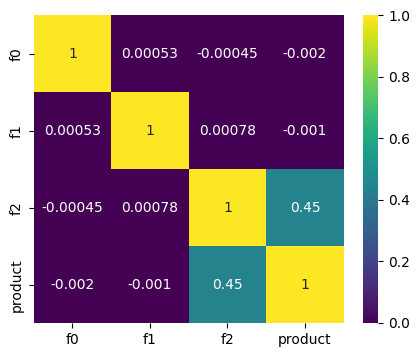

 
Распределение количественных данных на гистограммах -----------------------------


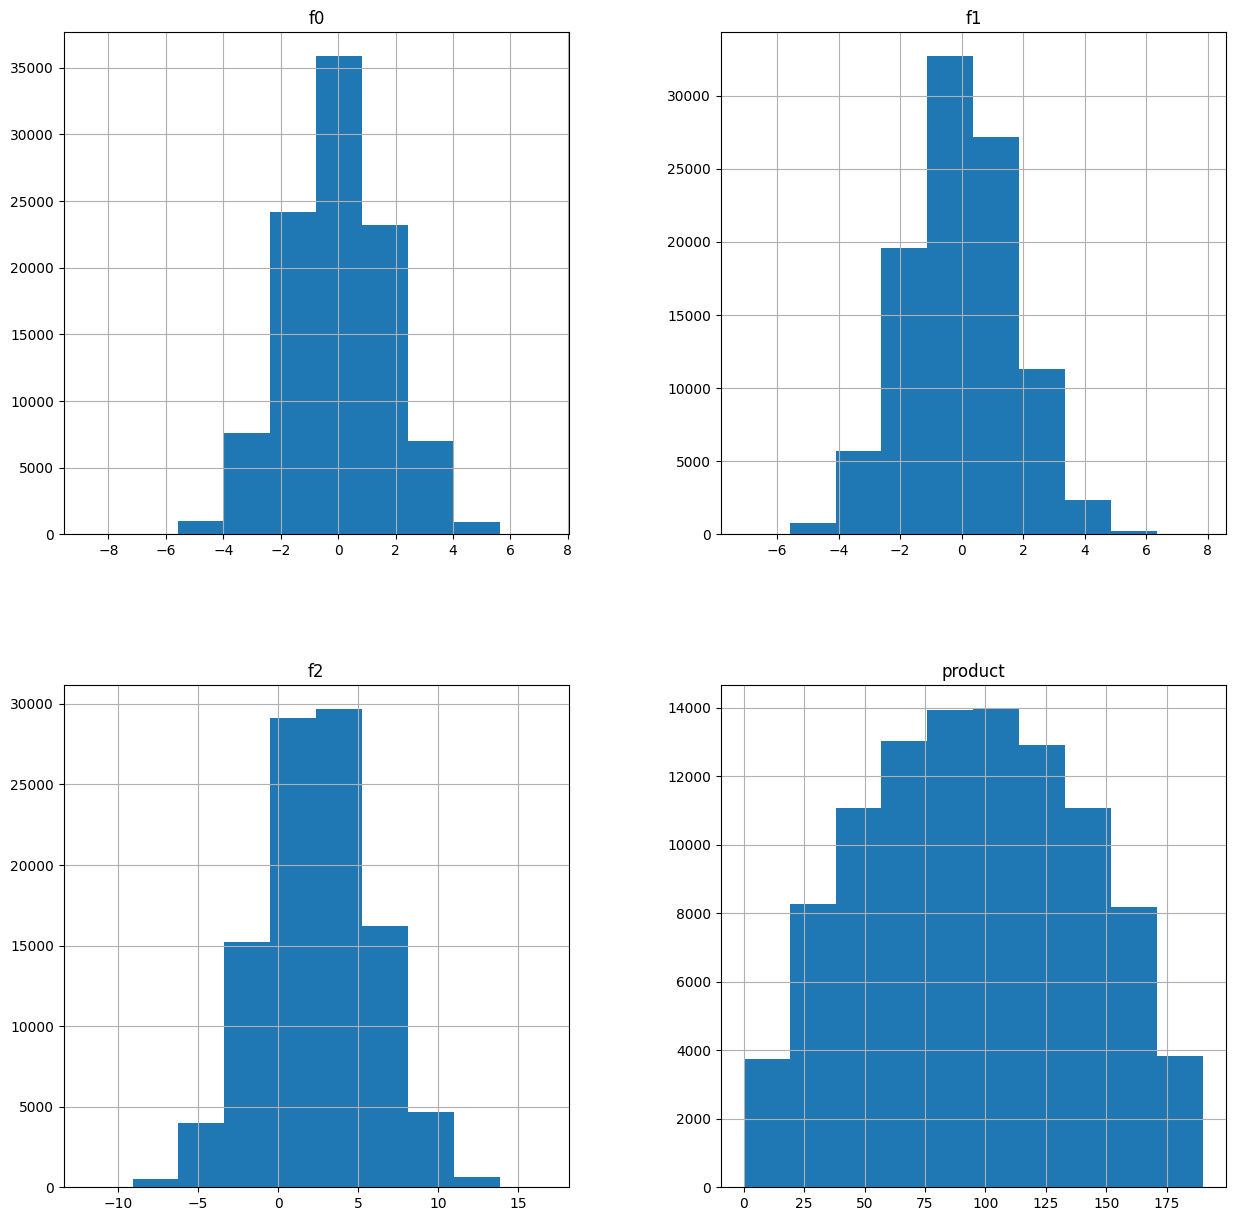

In [6]:
data_overview(d3)

1. В данных по региону 3 нет пропусков и явных дубликатов, количество строк в датасете — 100_000, типы данных соответствуют значениям в столбцах. 

2. Наблюдается средняя положительная корреляция (0.45) между объемом получаемого сырья и признаком f2.

3. Значения числовых переменных являются непрерывными (это видно на гистограммах). Значения переменной product имеют нормальное распределение.



### Общие замечания

Сравним объем добываемого сырья по регионам, посмотрим на данные на графике.

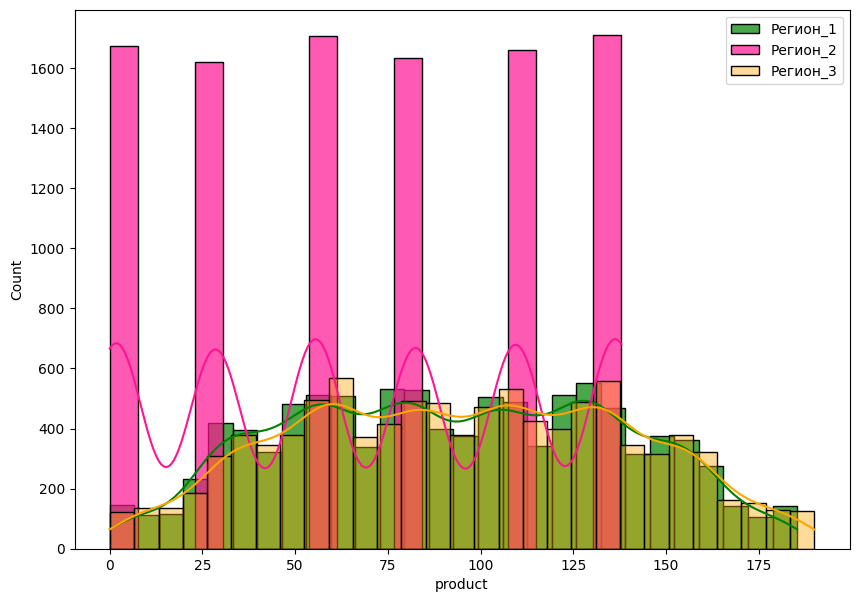

In [7]:
plt.figure(figsize=(10,7))
sns.histplot(d1['product'].sample(frac=0.1), label='Регион_1', 
             color="g", alpha=.7, kde=True)
sns.histplot(d2['product'].sample(frac=0.1), label='Регион_2', 
             color="deeppink", alpha=.7, kde=True)
sns.histplot(d3['product'].sample(frac=0.1), label='Регион_3', 
             color="orange", alpha=.4, kde=True)
plt.legend()
plt.show()


Мы видим, что в данных по второму региону присутствуют явно выраженные пики в нескольких участках графика, тогда как у данных по первому и третьему регионам распределение значений непрерывное. На этом графике видно, что второй регион по каким-то причинам сильно отличается от двух остальных.

### Выводы по разделу

В ходе обзора данных было выявлено:
1. Явных дубликатов и пропусков в данных нет.
2. Во втором регионе наблюдается прямая линейная зависимость между признаком f2 и количеством сырья.
3. Второй регион отличается от двух других по значениям в столбце product (имеются явно выраженные пиковые значения в нескольких участках графика).
4. Положительная линейная корреляция между f2 и product присутствует также в первом и третьем регионах, но она не так явно выражена, как во втором.

## Обучение и проверка модели

Создадим функцию для разбивки данных, обучения модели и выведения на экран необходимых показателей (метрики RMSE для модели линейной регрессии и среднего предсказанного запаса сырья в регионе).

In [8]:
def using_linear_regression(data):
    '''
    Функция принимает на вход датасет и делает следующее:
    - разбивает его на features и target
    - разбивает на тренировочную и валидационную подвыборки
    - масштабирует признаки через MinMaxScaler
    - выводит на экран метрику RMSE и среднее значение предсказания
    - строит график плотности распределений предсказанных и целевых значений
    - возвращает значения таргета и предсказаний
    
    '''
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=910)
    scaler=MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    model=LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predictions)
    print(f'RMSE модели по региону: {mse**0.5:.2f}')
    print(f'Средний запас предсказанного сырья в регионе: {predictions.mean():.2f} тыс. баррелей')
    plt.figure(figsize=(15,10))
    sns.kdeplot(data=pd.Series(predictions), label='Предсказанные значения')
    sns.kdeplot(data=target_valid, alpha=.3, label='Реальные значения')
    plt.legend(fontsize=16)
    plt.show()
    return target_valid, predictions

### Регион 1

RMSE модели по региону: 37.68
Средний запас предсказанного сырья в регионе: 92.52 тыс. баррелей


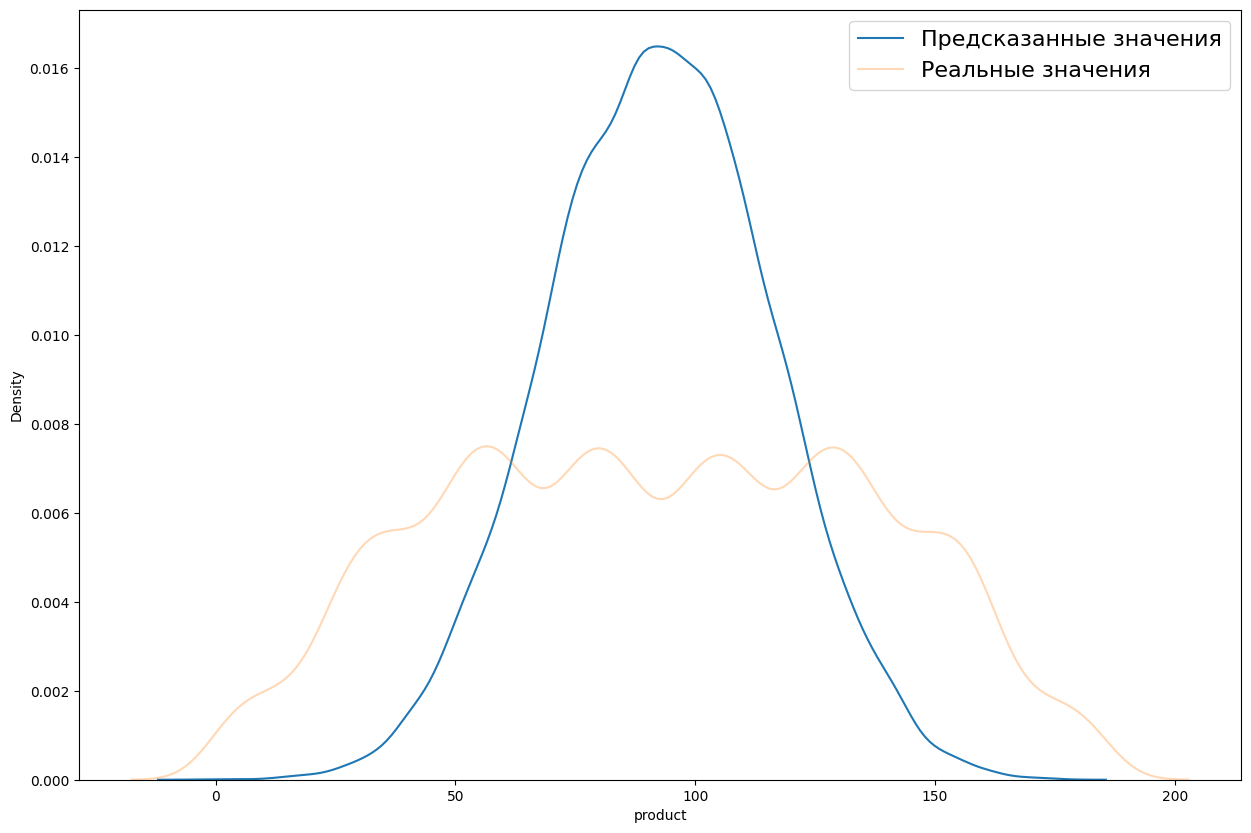

In [9]:
target_valid_1, predictions_1 = using_linear_regression(d1)

Мы видим, что плотность распределения значений, предсказанных моделью, отличается от плотности распределения реальных данных. Это говорит о том, что мы не можем в дальнейшем исследовании полагаться только на предсказания модели. 

В регионе 1 RMSE модели составляет 37.68, а средний запас предсказанного сырья — 92.52 тыс. баррелей

### Регион 2

RMSE модели по региону: 0.89
Средний запас предсказанного сырья в регионе: 69.09 тыс. баррелей


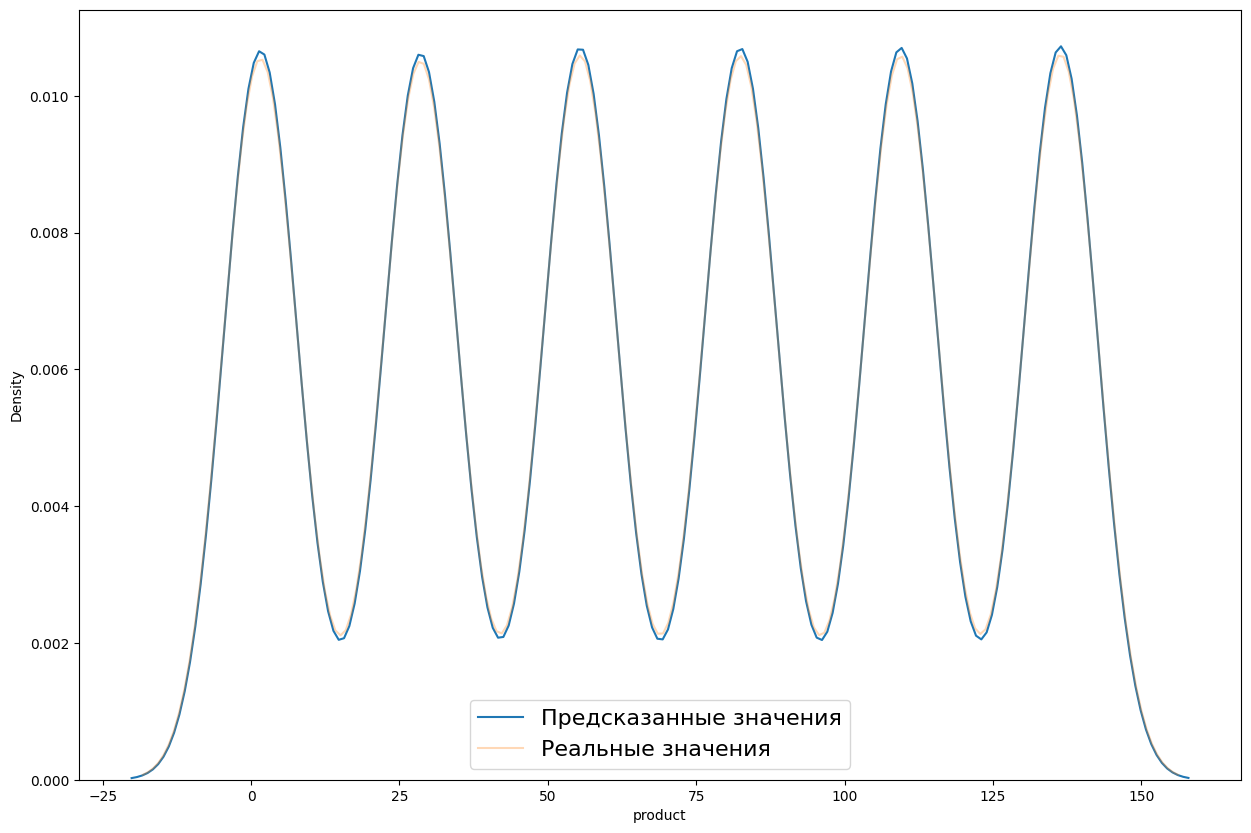

In [10]:
target_valid_2, predictions_2 = using_linear_regression(d2)

Средний запас предсказанного сырья в регионе 2 (69.09 тыс. баррелей) меньше, чем в регионе 1, однако качество модели значительно лучше. Об этом говорит низкое значение RMSE (0.89) и график, на котором кривые по предсказанным и реальным данным практически сливаются. Такая ситуация ожидаема, поскольку в наших данных есть признак, который практически на 100% коррелирует с целевым показателем.

### Регион 3

RMSE модели по региону: 40.02
Средний запас предсказанного сырья в регионе: 94.98 тыс. баррелей


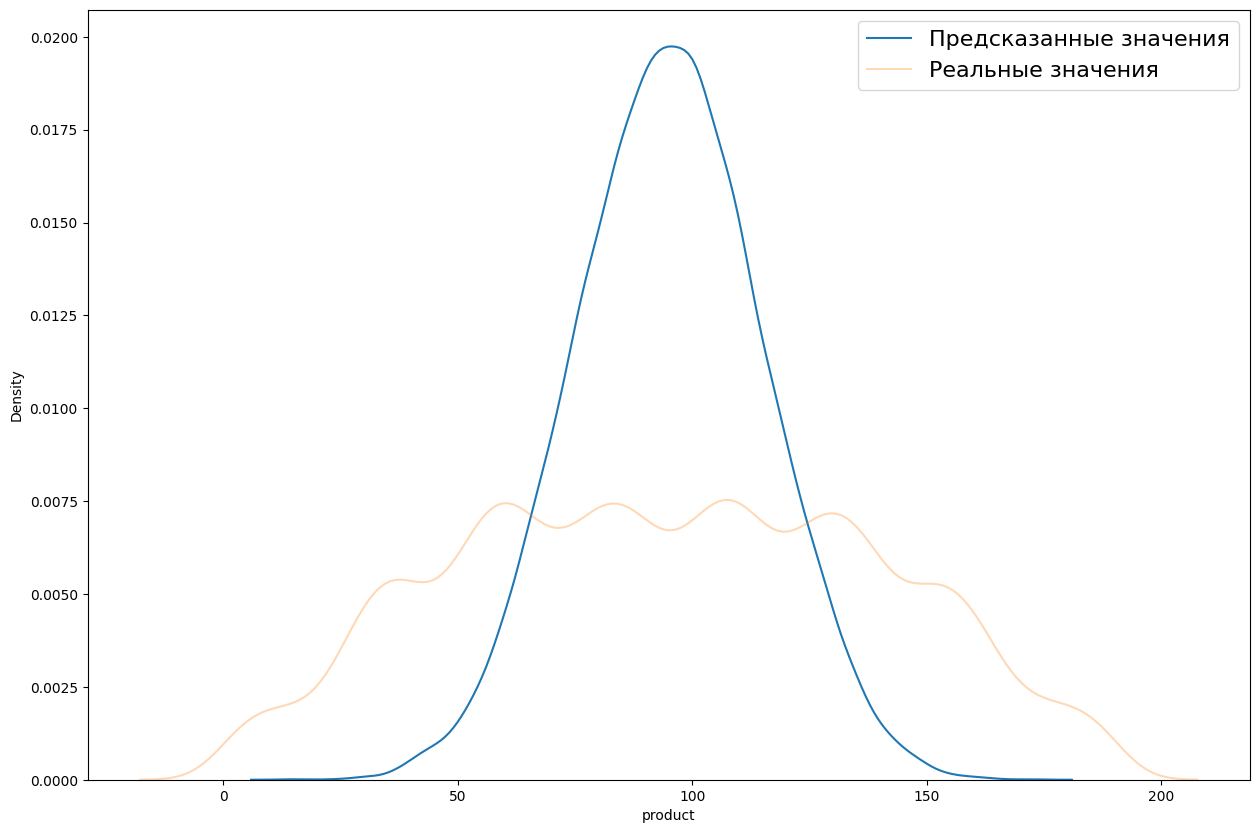

In [11]:
target_valid_3, predictions_3 = using_linear_regression(d3)

В регионе 3 самый большой из трех представленных средний запас предсказанного сырья (94.98 тыс. баррелей), но и самая большая ошибка модели (RMSE около 40). Добыча нефти в этом регионе может быть сопряжена с более высоким риском.

### Выводы по разделу

1. Мы обучили и проверили модели линейной регрессии на данных по трем представленным регионам.
2. Наилучший результат по RMSE показала модель по региону 2, поскольку в данных по этому региону целевой признак (product) практически на 100% коррелирует с одним из нецелевых (f2). Вместе с тем в этом регионе самый низкий из трех средний запас предсказанного сырья.
3. Модели, построенные на данных по первому и третьему регионам, показали сопоставимые показатели по среднему запасу и значению метрики RMSE: предсказанный запас в этих регионах больше, но и ошибка модели также выше, то есть принятие решений на основе предсказания моделей сопряжено с более высоким риском.

## Подготовка к расчёту прибыли

Сохраним значения для расчетов в отдельные переменные.

In [12]:
# Общий бюджет на разработку скважин в регионе
BUDGET = 10_000_000_000

# Цена 1000 баррелей
PRICE_PER_1000 = 450_000

# Минимальный объем сырья для безубыточной разработки новой скважины
min_oil_amount = BUDGET / 200 / PRICE_PER_1000
print(f'Минимальный объем сырья для безубыточной разработки скважины: {min_oil_amount:.2f} тыс. баррелей')

Минимальный объем сырья для безубыточной разработки скважины: 111.11 тыс. баррелей


Сравним рассчитанное минимальное значение объема сырья со средними запасами нефти в регионах.

In [13]:
def compare_mean_and_min(data):
    '''
    Функция для сравнения среднего объема сырья в регионе
    с минимальным количеством сырья,
    необходимым для безубыточной разработки скважины
    '''
    
    diff = data['product'].mean() - min_oil_amount
    
    if diff >= 0:
        print('В регионе достаточный объём сырья для безубыточной разработки новой скважины')
        
    else:
        print('В регионе недостаточный объём сырья') 
        print(f'Средний убыток c новой скважины составит {(int(abs(diff)) * PRICE_PER_1000)/1000000} млн рублей')

In [14]:
compare_mean_and_min(d1)

В регионе недостаточный объём сырья
Средний убыток c новой скважины составит 8.1 млн рублей


In [15]:
compare_mean_and_min(d2)

В регионе недостаточный объём сырья
Средний убыток c новой скважины составит 18.9 млн рублей


In [16]:
compare_mean_and_min(d3)

В регионе недостаточный объём сырья
Средний убыток c новой скважины составит 7.2 млн рублей


Из сравнения среднего запаса сырья в регионах с минимальным объемом, достаточным для безубыточной разработки новой скважины, следует, что все три представленных региона являются убыточными. 

## Расчёт прибыли и рисков 

Создадим функцию для расчета прибыли. Для этого выберем 200 скважин с максимальными предсказанными значениями, после чего найдем реальный показатель объема сырья по этим скважинам и рассчитаем прибыль (умножим стоимость тысячи баррелей на суммарный объем и вычтем затраты на разработку скважин). Для удобства разделим итоговое число на миллион, чтобы прибыль выводилась в млн рублей.

In [17]:
# Делаем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели
def profit(target, probs):
    probs_sorted = pd.Series(probs).sort_values(ascending=False)
    sel = target.iloc[probs_sorted.index][:200]
    return (PRICE_PER_1000 * sel.sum() - BUDGET)/1000000
    


Поскольку речь идет о возможной большой прибыли или больших убытках, нам нужно быть уверенными в том, что в наш отбор не вмешалась случайность. Для этого нужно найти вероятное распределение прибыли. Нам подходит техника bootstrap. 

Мы используем bootstrap (получение выборок с возвращением) 1000 раз и найдем распределение прибыли. Используя эти данные, найдем среднее значение прибыли, 95%-ный доверительный интервал и вероятность убытков (отрицательной прибыли).

Создадим функцию для проведения описанных расчетов.


In [18]:
def choose_best_region (target, predictions):
    
    # Пустой список, куда будем сохранять значения прибыли
    values = []

    # Бутстрапируем выборку
    state = np.random.RandomState(3337)
    for i in range(1000):
        target = target.reset_index(drop=True)
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        value = profit(target_subsample, predictions_subsample)
        values.append(value)

    # Считаем средний риск отрицательной прибыли
    values = pd.Series(values)
    risk = (values < 0).mean()

    # Рассчитываем доверительный интервал
    lower = values.quantile(q=0.025)
    upper = values.quantile(q=0.975)
    
    sns.kdeplot(values)

    print(f'Средняя прибыль в регионе: {values.mean():.2f} млн рублей')
    print(f'95% доверительный интервал: {lower:.2f}, {upper:.2f}')
    print(f'Средний риск убытков: {risk:.1%}')

    # сравниваем с риском в 2.5% (условия задачи)
    if (risk * 100) <= 2.5:
          print('Риск убытков меньше 2.5%')
    else:
          print('Риск убытков выше 2.5%')      

Средняя прибыль в регионе: 394.82 млн рублей
95% доверительный интервал: -154.35, 965.49
Средний риск убытков: 8.3%
Риск убытков выше 2.5%


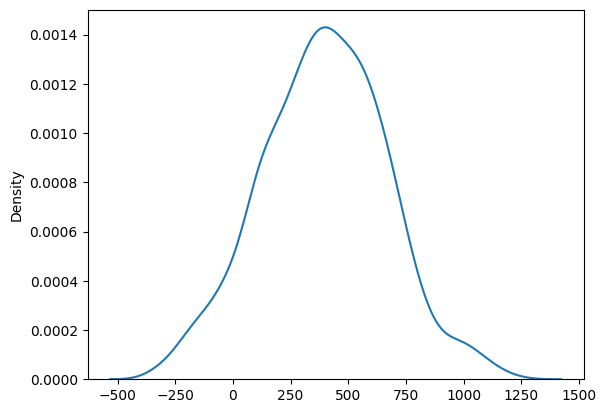

In [19]:
choose_best_region(target_valid_1, predictions_1)


Средняя прибыль в регионе: 480.91 млн рублей
95% доверительный интервал: 83.82, 878.17
Средний риск убытков: 0.9%
Риск убытков меньше 2.5%


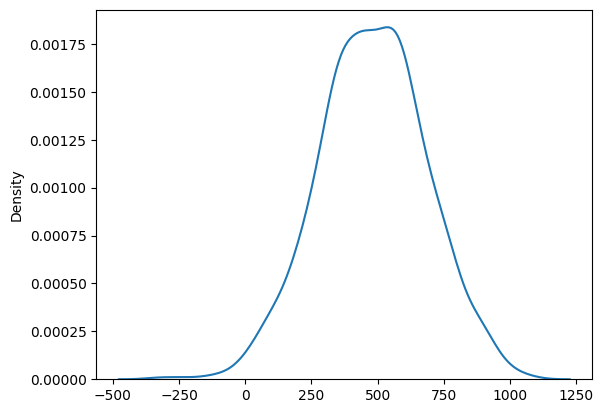

In [20]:
choose_best_region(target_valid_2, predictions_2)

Средняя прибыль в регионе: 342.87 млн рублей
95% доверительный интервал: -163.20, 904.46
Средний риск убытков: 9.3%
Риск убытков выше 2.5%


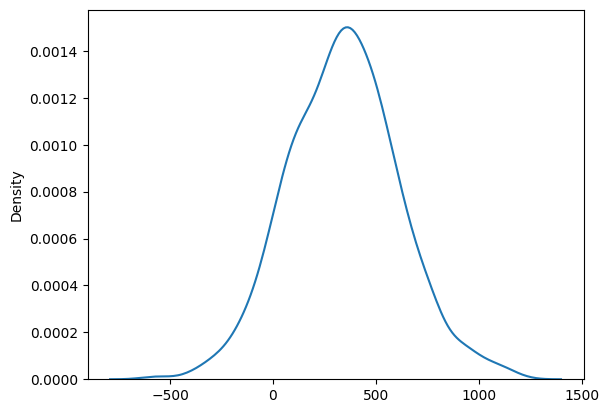

In [21]:
choose_best_region(target_valid_3, predictions_3)

Исходя из проведенных расчетов, наиболее надежным регионом является регион 2. Он показал самое высокое значение средней прибыли, а также самый низкий объем рисков (самую низкую долю вероятной отрицательной прибыли). Как мы помним, в этом регионе присутствует высокая корреляция между одним из нецелевых показателей (f2) и объемом добычи, поэтому модель, построенная на данных этого региона, показала самое низкое значение ошибки. Следовательно, для разработки новых скважин мы будем рекомендовать регион 2.


## Вывод по проекту

В результате исследования было установлено, что предпочительным регионом для разработки новых скважин является регион 2. Такой вывод был сделан исходя из представленных данных (бюджет, максимально возможные риски убытков, количество новых скважин, характеристики регионов). Второй регион отличается от двух других по ряду показателей. В этом регионе риск убытков наименьший (0.9%), а средняя прибыль наиболее высокая (480.91 млн рублей). Кроме того, модель, построенная на данных по этому региону, показала наименьшее значение ошибки (RMSE), поскольку целевой признак сильно коррелирует с одной из характеристик (f2). 